In [1]:
import numpy as np
import pandas as pd
import gzip
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from bs4 import BeautifulSoup  
import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score

In [4]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Apps_for_Android_5.json.gz')

In [5]:
df.head(30)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1N4O8VOJZTDVB,B004A9SDD8,Annette Yancey,"[1, 1]","Loves the song, so he really couldn't wait to ...",3.0,Really cute,1383350400,"11 2, 2013"
1,A2HQWU6HUKIEC7,B004A9SDD8,"Audiobook lover ""Kathy""","[0, 0]","Oh, how my little grandson loves this app. He'...",5.0,2-year-old loves it,1323043200,"12 5, 2011"
2,A1SXASF6GYG96I,B004A9SDD8,Barbara Gibbs,"[0, 0]",I found this at a perfect time since my daught...,5.0,Fun game,1337558400,"05 21, 2012"
3,A2B54P9ZDYH167,B004A9SDD8,"Brooke Greenstreet ""Babylove""","[3, 4]",My 1 year old goes back to this game over and ...,5.0,We love our Monkeys!,1354752000,"12 6, 2012"
4,AFOFZDTX5UC6D,B004A9SDD8,C. Galindo,"[1, 1]",There are three different versions of the song...,5.0,This is my granddaughters favorite app on my K...,1391212800,"02 1, 2014"
5,A331GYAT4ESYI3,B004A9SDD8,Felicia,"[3, 3]",THis is just so cute and a great app for littl...,5.0,so cute,1354665600,"12 5, 2012"
6,A2YEHF8T823TDC,B004A9SDD8,Gale White Miller,"[3, 4]",I watch my great grandson 4 days a week and it...,5.0,Terrific!,1381708800,"10 14, 2013"
7,A3699WHISXX94Z,B004A9SDD8,Janie Leonard,"[0, 0]",This app is wild and crazy. Little ones love ...,5.0,Five Little Monkeys,1389484800,"01 12, 2014"
8,A2BXV49EIES2TB,B004A9SDD8,Kayla,"[3, 4]",love love love this app. I was going through d...,5.0,love but to quite,1386720000,"12 11, 2013"
9,A37HM5TMCMHJES,B004A9SDD8,kmc,"[0, 0]","Very cute, with alot of items to move about. ...",5.0,Cute,1366934400,"04 26, 2013"


In [6]:
print("Summary statistics of numerical features : \n", df.describe())

print("\nTotal number of reviews: ",len(df))
print("\nTotal number of unique products: ", len(list(set(df['asin']))))

print("\nPercentage of reviews with neutral sentiment : {:.2f}%"\
      .format(df[df['overall']==3]["reviewText"].count()/len(df)*100))
print("\nPercentage of reviews with positive sentiment : {:.2f}%"\
      .format(df[df['overall']>3]["reviewText"].count()/len(df)*100))
print("\nPercentage of reviews with negative sentiment : {:.2f}%"\
      .format(df[df['overall']<3]["reviewText"].count()/len(df)*100))

Summary statistics of numerical features : 
              overall  unixReviewTime
count  752937.000000    7.529370e+05
mean        3.968931    1.368442e+09
std         1.342484    2.342230e+07
min         1.000000    1.134778e+09
25%         3.000000    1.354147e+09
50%         5.000000    1.370477e+09
75%         5.000000    1.388448e+09
max         5.000000    1.406074e+09

Total number of reviews:  752937

Total number of unique products:  13209

Percentage of reviews with neutral sentiment : 11.31%

Percentage of reviews with positive sentiment : 72.35%

Percentage of reviews with negative sentiment : 16.35%


In [7]:
#a = df.groupby("asin")
####c = df.groupby("asin").value_counts()
#s = df.groupby("asin").sum()
#over = group["overall"].sum()
#c = group["asin"].value_counts()

#v = over/c 
####print(v)
####print(over)
#z = list(v)
#####print(z)

#x = [str(i) for i in z]

#print(x)
#####b = list(a.groups.keys())
#####print(b)

In [8]:
#import csv

#with open('productrating.csv', 'w', newline='') as file:
#    writer = csv.writer(file)
#    #writer.writerows(b)
#    writer.writerows(x)

#b.to_csv("productrating.csv", index=False)
#v.to_csv("productrating.csv", index=False)

Text(0, 0.5, 'Count')

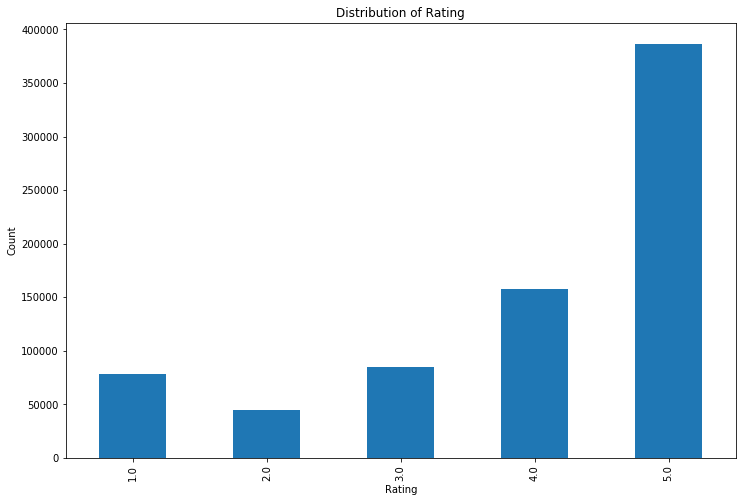

In [9]:
# Plot distribution of rating
plt.figure(figsize=(12,8))
# sns.countplot(df['Rating'])
df['overall'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

In [10]:
#df = df.sample(frac=0.1, random_state=0) #uncomment to use full set of data

# Drop missing values
df.dropna(inplace=True)

# Remove any 'neutral' ratings equal to 3
df = df[df['overall'] != 3]

# Encode 4s and 5s as 1 (positive sentiment) and 1s and 2s as 0 (negative sentiment)
df['Sentiment'] = np.where(df['overall'] > 3, 1, 0)
#df['Sentiment'] = np.where(df['overall'] == 3, 0, df['Sentiment'])
df.head()


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,Sentiment
1,A2HQWU6HUKIEC7,B004A9SDD8,"Audiobook lover ""Kathy""","[0, 0]","Oh, how my little grandson loves this app. He'...",5.0,2-year-old loves it,1323043200,"12 5, 2011",1
2,A1SXASF6GYG96I,B004A9SDD8,Barbara Gibbs,"[0, 0]",I found this at a perfect time since my daught...,5.0,Fun game,1337558400,"05 21, 2012",1
3,A2B54P9ZDYH167,B004A9SDD8,"Brooke Greenstreet ""Babylove""","[3, 4]",My 1 year old goes back to this game over and ...,5.0,We love our Monkeys!,1354752000,"12 6, 2012",1
4,AFOFZDTX5UC6D,B004A9SDD8,C. Galindo,"[1, 1]",There are three different versions of the song...,5.0,This is my granddaughters favorite app on my K...,1391212800,"02 1, 2014",1
5,A331GYAT4ESYI3,B004A9SDD8,Felicia,"[3, 3]",THis is just so cute and a great app for littl...,5.0,so cute,1354665600,"12 5, 2012",1


In [11]:
# Split data into training set and validation
X_train, X_test, y_train, y_test = train_test_split(df['reviewText'], df['Sentiment'], \
                                                    test_size=0.1, random_state=0)

print('Load %d training examples and %d validation examples. \n' %(X_train.shape[0],X_test.shape[0]))
print('Show a review in the training set : \n', X_train.iloc[10])

Load 553306 training examples and 61479 validation examples. 

Show a review in the training set : 
 im generally a fan of rpgs but this one blew it out of the park. great plot and gameplay as well. u might be wondering if this game is so amazing as i say it is why i rated it only 4 stars. well for one items in the game are quite expensive but thats not why i gave it 4 stars. it takes quite a while to gain all the coins u need for an item so be sure to save ur coins. also its easy to get tempted to buy in game purchases to further urself in the game which is bad for me since i tend to give in. but overall its a great game. i just wish saving money to buy items wasnt so long and tedious so ur either forced to wait or to purchase coins with real money


In [12]:
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False, \
             ):
    '''
    Convert a raw review to a cleaned review
    '''
    #text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", raw_text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words))

In [13]:
# Preprocess text data in training set and validation set
X_train_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))
print('Show a cleaned review in the training set : \n',  X_train_cleaned[10])
    
for d in X_test:
    X_test_cleaned.append(cleanText(d))

Show a cleaned review in the training set : 
 im generally a fan of rpgs but this one blew it out of the park great plot and gameplay as well u might be wondering if this game is so amazing as i say it is why i rated it only stars well for one items in the game are quite expensive but thats not why i gave it stars it takes quite a while to gain all the coins u need for an item so be sure to save ur coins also its easy to get tempted to buy in game purchases to further urself in the game which is bad for me since i tend to give in but overall its a great game i just wish saving money to buy items wasnt so long and tedious so ur either forced to wait or to purchase coins with real money


In [14]:
def modelEvaluation(predictions):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))

In [15]:
import time

In [16]:
start = time.perf_counter() 


# Building a pipeline
estimators = [("tfidf", TfidfVectorizer()), ("lr", LogisticRegression())]
model = Pipeline(estimators)


# Grid search
params = {"lr__C":[0.1, 1, 10], #regularization param of logistic regression
          "tfidf__min_df": [1, 3], #min count of words 
          "tfidf__max_features": [1000, None], #max features
          "tfidf__ngram_range": [(1,1), (1,2)], #1-grams or 2-grams
          "tfidf__stop_words": [None, "english"]} #use stopwords or don't

grid = GridSearchCV(estimator=model, param_grid=params, scoring="accuracy", n_jobs=-1)
grid.fit(X_train_cleaned, y_train)
print("The best paramenter set is : \n", grid.best_params_)


# Evaluate on the validaton set
predictions = grid.predict(X_test_cleaned)

end = time.perf_counter()  
 
print("Time elapsed during the calculation:", end - start) 

D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The best paramenter set is : 
 {'lr__C': 10, 'tfidf__max_features': None, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None}
Time elapsed during the calculation: 2343.8967553


In [17]:
modelEvaluation(predictions)


Accuracy on validation set: 0.9458

AUC score : 0.8993


In [19]:
!pip install pickle-mixin

  Created wheel for pickle-mixin: filename=pickle_mixin-1.0.2-cp37-none-any.whl size=6003 sha256=9f6367070141fc7b6b6c6d0cf57eda60282497aec3adec65652b48fcb022006a
  Stored in directory: C:\Users\vatsa\AppData\Local\pip\Cache\wheels\cd\05\42\71de70fa36b9cbb7657bb5793a16f8028c1cdc1bdd3b8e1ac3
Successfully built pickle-mixin


In [20]:
import pickle

In [22]:
pickle.dump(grid,open("model.sav","wb"))